In [78]:
# This code is written to support the experiments in the book titled:
# "Adaptive Machine Learning Algorithms"
# by
# Chanchal Chatterjee and Vwani P. Roychowdhury
# August 2021
#
# Experiments for Chapter 8 (INSECTS-incremental_balanced_norm.csv Data)
#
# Author: Chanchal Chatterjee
#

In [79]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf


In [83]:
# Data obtained from UCI clickstream dataset for online shopping 
# https://archive.ics.uci.edu/ml/datasets/clickstream+data+for+online+shopping
# Load data into your unique bucket. 
# Here gs://chanchal_book_bucket1/e-shop-clothing-2008.csv

In [84]:
dataset   = pd.read_csv("gs://chanchal_book_bucket1/e-shop-clothing-2008.csv")
dataset = dataset.dropna()
dataset = dataset.drop(['year','month','day','sessionID','clothing_model'],1)
print(dataset.shape)
print(dataset.head())


(165474, 9)
   order  country  main_category  colour  location  model photography  price  \
0      1       29              1       1         5                  1     28   
1      2       29              1       1         6                  1     33   
2      3       29              2      10         2                  1     52   
3      4       29              2       6         6                  2     38   
4      5       29              2       4         3                  2     52   

   price2  page  
0       2     1  
1       2     1  
2       1     1  
3       2     1  
4       1     1  


------------------------------------------
### Adaptive Linear Eigen Decomposition

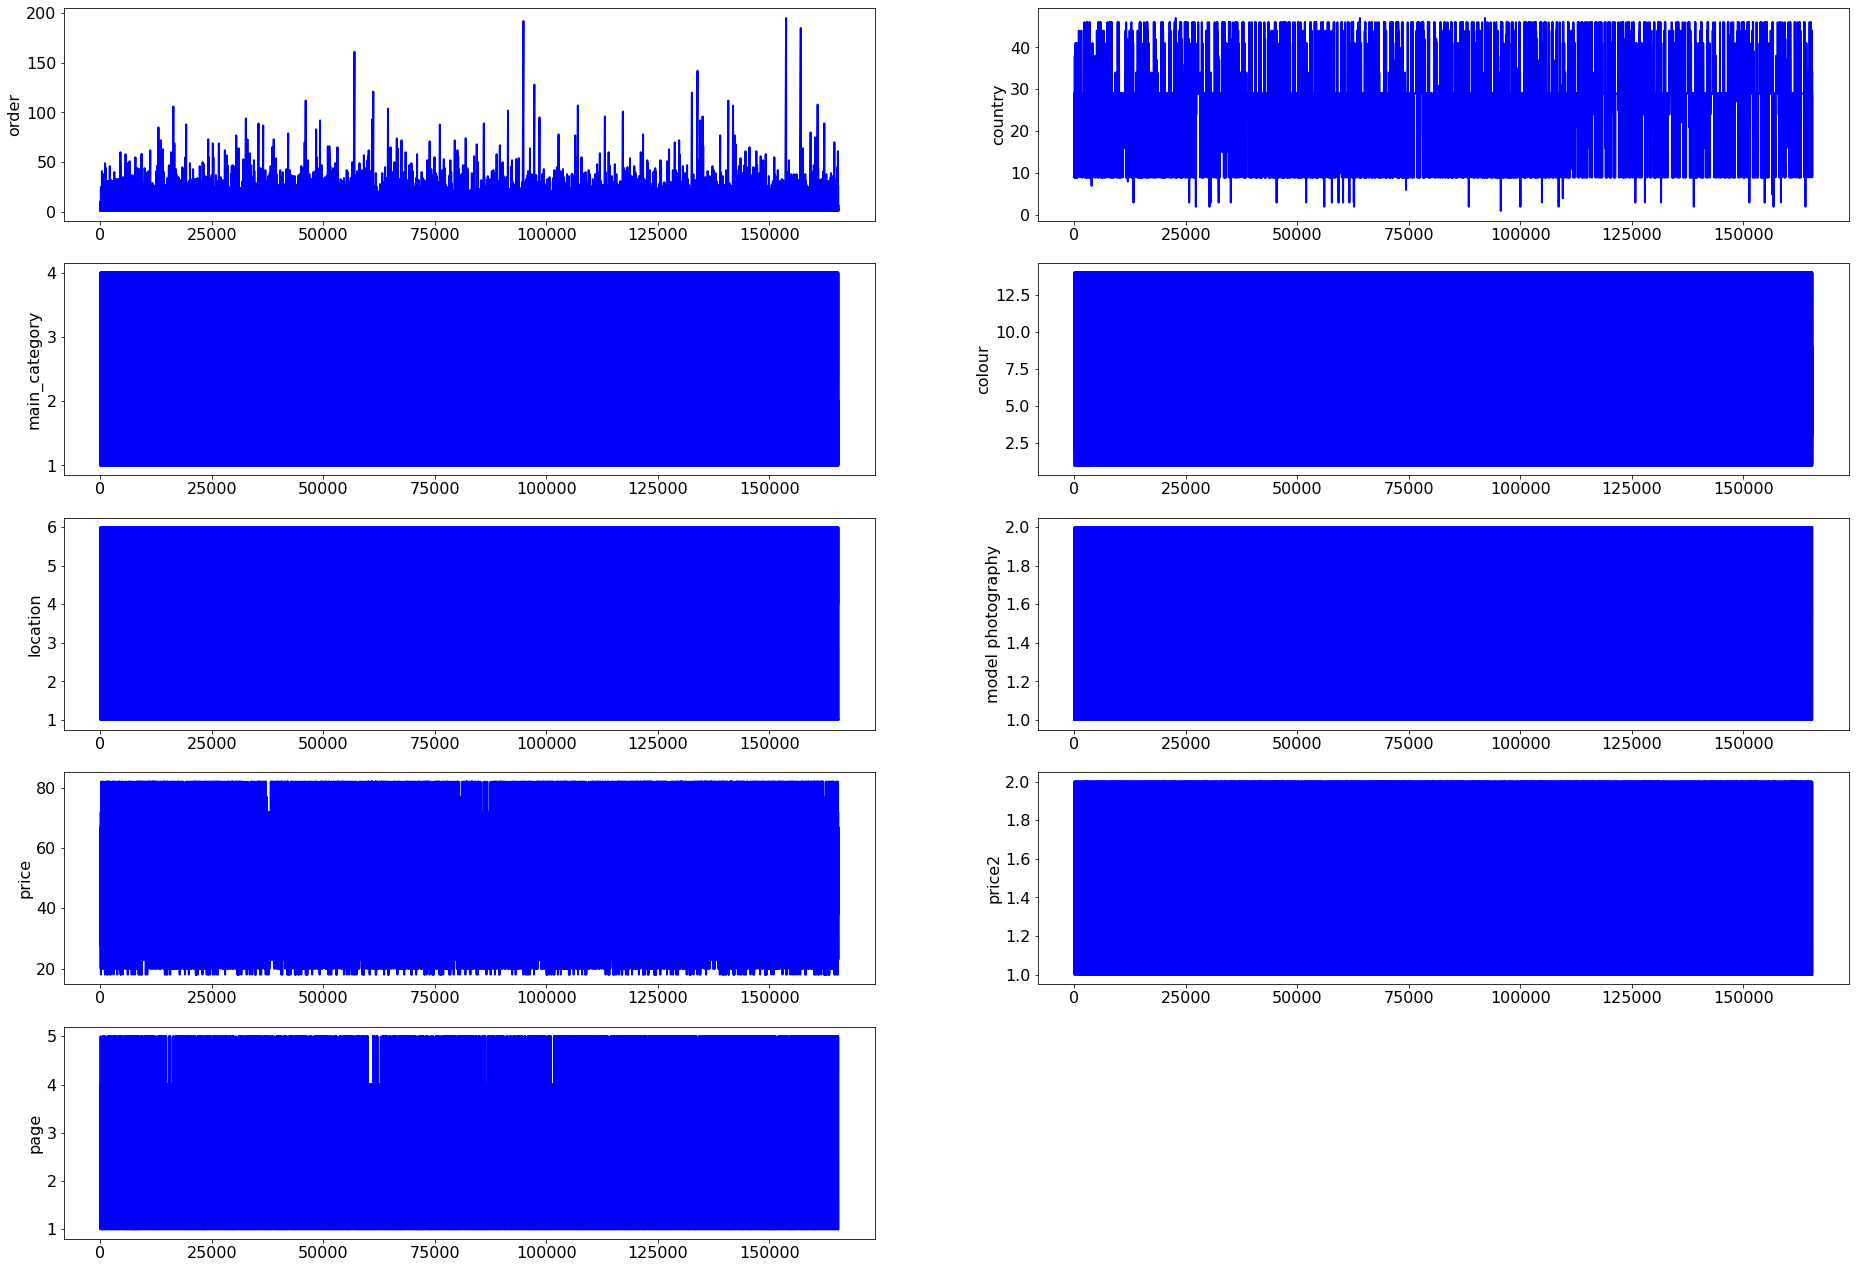

In [85]:
plt.figure(figsize=(32, 32))
plt.rcParams.update({'font.size': 16})
cols = dataset.columns
for i in range(dataset.shape[1]):
    plt.subplot(7, 2, i+1)
    plt.ylabel(cols[i])
    plt.plot(dataset[cols[i]], lw=2, color='b')
plt.show()


In [86]:
# Adaptive algorithm
from numpy import linalg as la

nSamples = dataset.shape[0]
nDim = dataset.shape[1]

A = np.zeros(shape=(nDim,nDim)) # stores adaptive correlation matrix
N = np.zeros(shape=(1,nDim)) # stores eigen norms
W = 0.1 * np.ones(shape=(nDim,nDim)) # stores adaptive eigenvectors
for iter in range(nSamples//1):
    cnt = iter + 1
    x = np.array(dataset.iloc[iter])
    x = x.reshape(nDim,1)
    A = A + (1.0/cnt)*((np.dot(x, x.T)) - A)
    etat = 1.0/(10000 + cnt)
    # Deflated Gradient Descent
    W = W + etat*(A @ W - 0.5*W @ np.triu(W.T @ A @ W) - 0.5*A @ W @ np.triu(W.T @ W))
    newnorm = la.norm(W, axis=0)
    N = np.vstack([N, newnorm])
print("W=\n", W)


W=
 [[ 0.18529643  0.97631414  0.10161502 -0.03824329 -0.01221379 -0.00748514
  -0.00479546 -0.0035982  -0.00304989]
 [ 0.49536741 -0.01631742 -0.84299096 -0.17952026 -0.06810289 -0.04343499
  -0.02685004 -0.01904315 -0.01507725]
 [ 0.04238973  0.01994296 -0.0684788   0.07933911  0.10034887  0.06981632
   0.04536341  0.03696804  0.03538778]
 [ 0.11237671  0.0258873  -0.12538044  0.97490161 -0.07993499 -0.07532834
  -0.0339926  -0.01592933 -0.00774693]
 [ 0.05857504  0.00599179 -0.04719498  0.06086398  0.90711756  0.61742576
   0.34977158  0.22186003  0.15498903]
 [ 0.02254062  0.00404219 -0.0215959   0.02044713  0.06718282  0.04671335
   0.02822897  0.02015584  0.01659144]
 [ 0.83684715 -0.21231067  0.50311535 -0.02789798 -0.02035974 -0.01315029
  -0.00772056 -0.00509374 -0.00370517]
 [ 0.02560937  0.00627809 -0.04334058  0.01356936  0.11177315  0.07673181
   0.04425595  0.02920052  0.02173791]
 [ 0.03070586  0.01758014 -0.03050351  0.06701042  0.00818234  0.00756925
   0.00949101  0.0

In [87]:
import math
from scipy.linalg import eigh
WTW = W.T @ W
WTAW = W.T @ A @ W
#print("WTW=\n", WTW)
#print("WTAW=\n", WTAW)
eigvals, eigvecs = eigh(A)
#print("PHI=\n", eigvecs)
print("Lambda=\n", eigvals)
print("Diags of WTAW")
print([WTAW[i,i] for i in range(len(WTAW[0]))])
print("Diags of WTW")
print([WTW[i,i] for i in range(len(WTW[0]))])


Lambda=
 [1.59302655e-01 3.39779207e-01 7.10129289e-01 1.50244904e+00
 3.38296222e+00 1.92846919e+01 8.40672651e+01 1.85469778e+02
 2.92230613e+03]
Diags of WTAW
[2922.306121719499, 185.46975297464152, 84.06697466394918, 19.28438357597208, 2.914587658060093, 1.3668893381503187, 0.43698270961936786, 0.1781955487505199, 0.09025198793718651]
Diags of WTW
[1.000000000013902, 0.999999969017446, 0.9999966374166411, 0.9999932554332208, 0.8615971796914261, 0.40200600390913643, 0.12920256930852572, 0.05266383647814124, 0.02659475150038235]


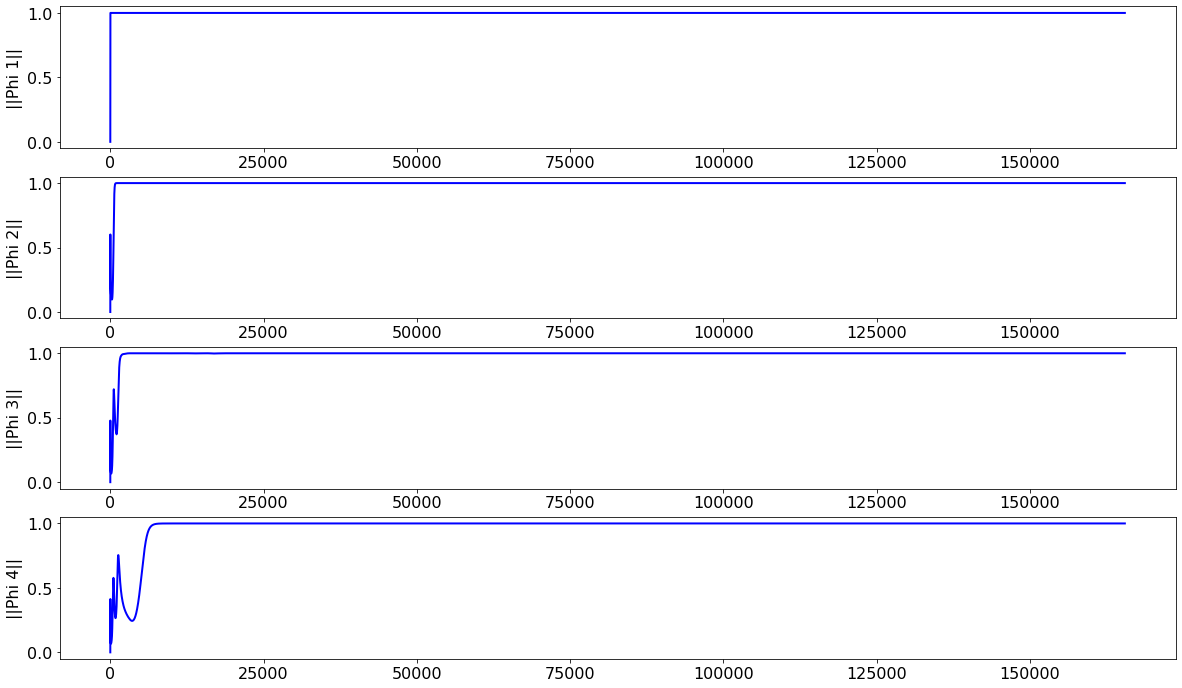

In [88]:
cols = dataset.columns
norms = pd.DataFrame({cols[0]: N[:, 0], cols[1]: N[:, 1], cols[2]: N[:, 2], cols[3]: N[:, 3]})

plt.figure(figsize=(20, 12))
plt.rcParams.update({'font.size': 16})
cols = norms.columns
for i in range(4):
    plt.subplot(4, 1, i+1)
    plt.ylabel('||Phi {}||'.format(i+1))
    plt.plot(norms[cols[i]], lw=2, color='b')
plt.show()

------------------------------------------
### Adaptive Linear Generalized Eigen Decomposition

In [89]:
dataset1 = dataset.drop(['price2'], 1)
print(dataset1.shape)
print(dataset1.head())


(165474, 8)
   order  country  main_category  colour  location  model photography  price  \
0      1       29              1       1         5                  1     28   
1      2       29              1       1         6                  1     33   
2      3       29              2      10         2                  1     52   
3      4       29              2       6         6                  2     38   
4      5       29              2       4         3                  2     52   

   page  
0     1  
1     1  
2     1  
3     1  
4     1  


In [90]:
# Adaptive algorithm
from numpy import linalg as la

nSamples = dataset1.shape[0]
nDim = dataset1.shape[1]

classes = np.array(dataset['price2']-1)
classes_categorical = tf.keras.utils.to_categorical(classes, num_classes=2)

M = np.zeros(shape=(nDim,2)) # stores adaptive correlation matrix
B = np.zeros(shape=(nDim,nDim)) # stores adaptive correlation matrix
N = np.zeros(shape=(1,nDim)) # stores eigen norms
W = 0.1 * np.ones(shape=(nDim,nDim)) # stores adaptive eigenvectors
for iter in range(nSamples//1):
    cnt = iter + 1
    x = np.array(dataset1.iloc[iter])
    x = x.reshape(nDim,1)
    B = B + (1.0/cnt)*((np.dot(x, x.T)) - B)
    y = classes_categorical[iter].reshape(2,1)
    M = M + (1.0/cnt)*((np.dot(x, y.T)) - M)
    A = M @ M.T
    etat = 1.0/(1000000 + cnt)
    # Deflated Gradient Descent
    W = W + etat*(A @ W - 0.5* B @ W @ np.triu(W.T @ A @ W) - 0.5*A @ W @ np.triu(W.T @ B @ W))
    WTBW = W.T @ B @ W
    newnorm = [math.sqrt(WTBW[i,i]) for i in range(len(WTBW[0]))]
    N = np.vstack([N, newnorm])
print("W=\n", W)


W=
 [[-0.00346405  0.03324709  0.04294083  0.04652255  0.04960669  0.05266281
   0.0569436   0.06253304]
 [-0.00658986  0.01159811 -0.05463931 -0.0822432  -0.08981583 -0.08566658
  -0.07730095 -0.06856051]
 [ 0.08273317  0.08940304  0.08898183  0.08895581  0.08946701  0.0901912
   0.09096867  0.09171257]
 [ 0.03711464  0.07510464  0.06995483  0.07076507  0.07245809  0.07462139
   0.07704064  0.07954702]
 [ 0.07700148  0.08611487  0.07488883  0.07043728  0.06885259  0.06904182
   0.07006763  0.07137204]
 [ 0.09322015  0.09557793  0.09234089  0.0910422   0.09074653  0.09104456
   0.09160437  0.09223238]
 [ 0.00565793 -0.04580151 -0.00274273  0.01323656  0.0171197   0.01369823
   0.00736579  0.00045441]
 [ 0.08665662  0.09331169  0.08954751  0.08836307  0.08824653  0.08877413
   0.08960409  0.09052588]]


In [91]:
import math
from scipy.linalg import eigh
WTAW = W.T @ A @ W
WTBW = W.T @ B @ W
#print("WTBW=\n", WTBW)
#print("WTAW=\n", WTAW)
eigvals, eigvecs = eigh(A, B)
#print("PHI=\n", eigvecs)
print("Lambda=\n", eigvals)
print("Diags of WTAW")
print([WTAW[i,i] for i in range(len(WTAW[0]))])
print("Diags of WTBW")
print([math.sqrt(WTBW[i,i]) for i in range(len(WTBW[0]))])


Lambda=
 [-3.32625332e-16 -2.34429464e-16 -5.24849693e-17  1.19587126e-16
  2.03920234e-16  6.82713110e-16  2.08879470e-01  4.99781189e-01]
Diags of WTAW
[0.4863488686958698, 0.09017717388521969, 8.85366310562816e-05, 0.009669868343808676, 0.015162591629708951, 0.010183737396158903, 0.003585663315893558, 0.000255456195159196]
Diags of WTBW
[1.0209914945736813, 0.9708786247876753, 0.8579000672143731, 0.9927236047825904, 1.0621850283967478, 1.0735931270587395, 1.0865947927504267, 1.1267558805400957]


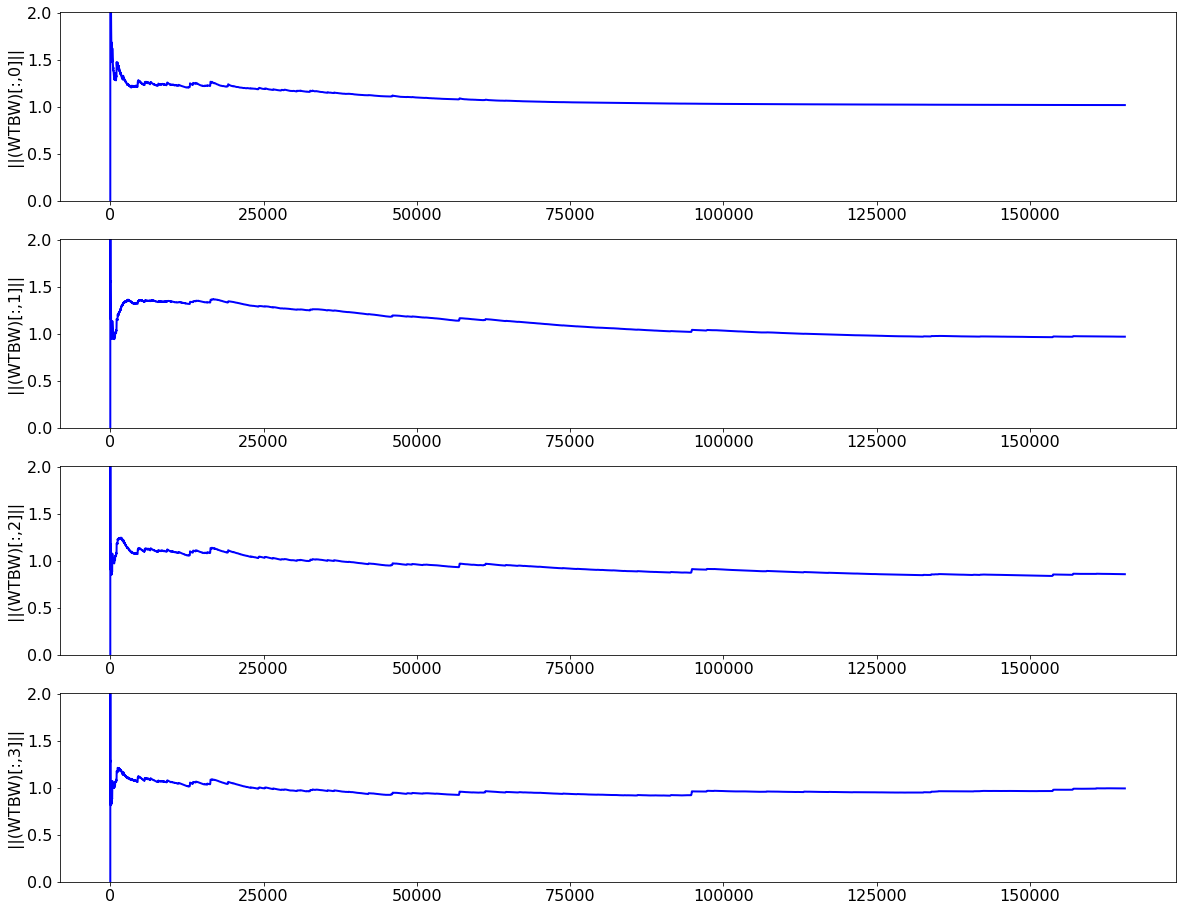

In [92]:
cols = dataset1.columns
norms = pd.DataFrame({cols[0]: N[:, 0], cols[1]: N[:, 1], cols[2]: N[:, 2], cols[3]: N[:, 3], \
                      cols[4]: N[:, 4], cols[5]: N[:, 5], cols[6]: N[:, 6], cols[7]: N[:, 7]})

plt.figure(figsize=(20, 16))
plt.rcParams.update({'font.size': 16})
cols = norms.columns
for i in range(4):
    plt.subplot(4, 1, i+1)
    plt.ylabel('||(WTBW)[:,{}]||'.format(i))
    plt.ylim([0,2.01])
    plt.plot(norms[cols[i]], lw=2, color='b')
plt.show()
